# Project 5: Multimodal Models

In this project, you will explore multimodal tasks that interface language with vision, such as image retrieval, caption retrieval, and image captioning. We will work with [Concadia](https://arxiv.org/abs/2104.08376), an image-text dataset scraped from Wikipedia focused on the relationship between images and the textual context. First, you will use CLIP for image retrieval and caption retrieval. Then, we will explore how implementing a Rational Speech Acts inference procedure can improve retrieval performance. Finally, we will generate our own captions for these images.

## Setup

First, we will install the required dependencies and download the dataset.

In Kaggle, you may want to turn on file persistence (Right Sidebar > Notebook Options > Persistence > Files only) so you don't have to re-download the dataset every time you restart this notebook.

In [1]:
%%capture
!pip install transformers
!pip install gdown

In [2]:
%%capture
# Download dataset
# resized.zip
!gdown --id 1gDhVlOwcGcwBT5LWYwgn9xEElGlKVpFb
!unzip /kaggle/working/resized.zip
# wiki_split.json
!gdown --id 1kiTSiqk7y7JdHssXjoLwcOomC7lhb5k8

In [3]:
import json
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, AutoProcessor, AutoModelForCausalLM
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Before proceeding, let's verify that we're connected to a GPU runtime and that torch can detect the GPU. We'll define a variable device here to use throughout the code so that we can easily change to run on CPU for debugging.

In [4]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Dataset Setup

For this project, let's load up the validation split of the dataset and inspect a sample.

Concadia consists of images paired with _captions_, which provide additional context, and _descriptions_, which are intended to replace the image (e.g. for alt-text). We'll be comparing captions and descriptions for various multimodal tasks, so feel free to explore what those instances look like. You may also want to refer to the paper for context.

In [5]:
with open("/kaggle/working/wiki_split.json") as f:
    data = json.load(f)["images"]
val = [d for d in data if d["split"] == "val"]
print("Number of validation examples:", len(val))

Number of validation examples: 9693


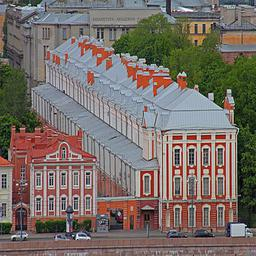

Caption: Rand completed a three-year program at Petrograd State University.
Description: The Twelve Collegia of what was then Petrograd State University


In [6]:
# Inspect a data sample
img = Image.open(f"/kaggle/working/resized/{val[0]['filename']}")
display(img)
print("Caption:", val[0]["caption"]["raw"])
print("Description:", val[0]["description"]["raw"])

## Part 1: Image & Text Retrieval


First, we'll retrieve images from the dataset from captions and descriptions, and evaluate the relative performance of retrieving with captions vs. descriptions for a subset of the validation set.

In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Evaluate on a subset of the validation set
MAX_LEN = 70
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
data = [d for d in val if len(tokenizer(d["description"]["raw"])["input_ids"]) < MAX_LEN
        and len(tokenizer(d["caption"]["raw"])["input_ids"]) < MAX_LEN]
data = data[:1000]

Token indices sequence length is longer than the specified maximum sequence length for this model (152 > 77). Running this sequence through the model will result in indexing errors


In [8]:
data[0].keys()

dict_keys(['article_id', 'filename', 'orig_filename', 'description', 'caption', 'context', 'split'])

In [9]:
def rank_images(queries, images):
    """Ranks images for a batch of text queries by their CLIP similarity score.
    Args:
        queries: a list with batch of N text queries
        images: a list with a batch of N images
    Returns:
         A NxN array with image indices sorted by retrieval score for each query.
    """
    # YOUR CODE HERE
    ##
    inputs= processor(text=queries, images=images,return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        outputs=model(**inputs)
        scores = outputs.logits_per_text
        ranked_images_indices = [sorted(list(range(len(images))), key=lambda x: scores[i][x], reverse=True) for i in range(len(images))]
#     print(scores)
    return ranked_images_indices

    

You will implement several retrieval metrics:
* Mean reciprocal rank: the average 1/rank of the true image for a query
* Top-1 accuracy: the % of instances where the true image is the top result for a query
* Top-k accuracy (k=10): the % of instances where the true image is in the top k results for a query

In [10]:
def mrr(batch_outputs):
    # YOUR CODE HERE
    ###
    tot_rank=[]
    true_indices=list(range(len(batch_outputs)))
#     failed_indices=[]
    for true_index,output in enumerate(batch_outputs):
        rank_rec=1/(output.index(true_index)+1)
        tot_rank.append(rank_rec)
    return sum(tot_rank)/len(tot_rank)     

def top1_accuracy(batch_outputs):
    # YOUR CODE HERE
    ### 
    true_percent=0
    for true_index,output in enumerate(batch_outputs):
        if true_index==output[0]:
            true_percent+=1
    return true_percent/len(batch_outputs)
    
def topk_accuracy(batch_outputs, k=10):
    # YOUR CODE HERE
    ###
    true_percent=0
    for true_index,output in enumerate(batch_outputs):
        if true_index in output[:k]:
            true_percent+=1
    return true_percent/len(batch_outputs)

Now we'll compute each of these metrics for retrieving images based on captions vs. descriptions.

You should be getting >.60 MRR, >50% top-1 accuracy and >80% top-10 accuracy for both.

In [11]:
captions = [ex["caption"]["raw"] for ex in data]
descs = [ex["description"]["raw"] for ex in data]
images = [Image.open(f"/kaggle/working/resized/{ex['filename']}") for ex in data]

In [12]:
# import os
# directory = '/kaggle/working/results'
# if not os.path.exists(directory):
#     os.makedirs(directory)

In [13]:
batch_outputs_cap = rank_images(captions, images)
print("Caption-based retrieval:")
cap_mrr=mrr(batch_outputs_cap)
print("MRR: ", cap_mrr)
print("Top-1 acc: ", top1_accuracy(batch_outputs_cap))
print("Top-10 acc: ", topk_accuracy(batch_outputs_cap))
np.save("image_retrieval_caption.npy", batch_outputs_cap)

batch_outputs_desc = rank_images(descs, images)
print("Descriptions-based retrieval:")
desc_mrr=mrr(batch_outputs_desc)
print("MRR: ", desc_mrr)
print("Top-1 acc: ", top1_accuracy(batch_outputs_desc))
print("Top-10 acc: ", topk_accuracy(batch_outputs_desc))
np.save("image_retrieval_desc.npy", batch_outputs_desc)

Caption-based retrieval:
MRR:  0.6964466665955885
Top-1 acc:  0.579
Top-10 acc:  0.908
Descriptions-based retrieval:
MRR:  0.692618061705691
Top-1 acc:  0.589
Top-10 acc:  0.873


In [16]:
test=np.load("image_retrieval_desc.npy")
type(test),type(test[0])

(numpy.ndarray, numpy.ndarray)

Now we'll look at the inverse problem: for a given image, does the corresponding caption or description in the dataset score higher?

In [17]:
def caption_better(captions, descriptions, images):
    """For a batch of paired (caption, description, image), returns True for each batch element
    if the caption scores higher for the image than the description.
    Args:
        captions: a list with batch of N text captions
        descriptions:  list with batch of N text descriptions
        images: a list with a batch of N images
    Returns:
         A list of N booleans, True if the caption scores higher for the image
    """
    # YOUR CODE HERE
    ##
    is_better=[]
    dif_score=[]
    caption_input=processor(text=captions, images=images,return_tensors="pt", padding=True, truncation=True).to("cuda")
    description_input=processor(text=descriptions, images=images,return_tensors="pt", padding=True, truncation=True).to("cuda")
    with torch.no_grad():
        cap_output=model(**caption_input)
        des_output=model(**description_input)
        cap_score = cap_output.logits_per_image
        des_score =  des_output.logits_per_image
    for i in range(len(images)):
        cap=cap_score[i][i]
        des=des_score[i][i]
        dif=cap-des
        if cap>des:
            is_better.append(True)
            dif_score.append((i,dif))
        else:
            is_better.append(False)
    return is_better,dif_score
        
better_rate,dif_score=caption_better(captions, descs, images)
print("% of examples where caption scores more highly:", np.mean(better_rate))

% of examples where caption scores more highly: 0.525


You should see >50% of examples where the caption scores more highly.

### Qualitative Analysis Part 1: Image & Text Retrieval

In the report, provide the following analysis:
* Investigate a couple of examples where image retrieval fails, and systematic model issues you observe (if any).
* Are there any differences between the failure modes of retrieving based on captions and retrieving based on descriptions (e.g. for the same example)? You may also look at some examples of caption and description text and comment on where you think their performance could differ in general.
* Discuss how the retrieval metrics affect analysis. All of these metrics are commonly reported in information retrieval — how do the metrics (and your qualitiative analysis from the last two steps) provide different perspectives on model performance? 
* Investigate a couple of examples where the paired caption scores more highly than the paired description for an image. Are there any patterns you observe that determine whether the caption or the description scores more highly?

In [18]:
# YOUR CODE HERE
### 
# cap_failed,desc_failed,dif_score
# dif_score
cap_incorrect = [b[:10] for i, b in enumerate(batch_outputs_cap) if i not in b[:10]] #错误的index的预测出来的top10
cap_incorrect_idxs = [i for i, b in enumerate(batch_outputs_cap) if i not in b[:10]]
desc_incorrect = [b[:10] for i, b in enumerate(batch_outputs_desc) if i not in b[:10]]
desc_incorrect_idxs = [i for i, b in enumerate(batch_outputs_desc) if i not in b[:10]]
print(len(cap_incorrect_idxs),len(desc_incorrect_idxs))
common_incorrect_idxs=[i for i in cap_incorrect_idxs if i in desc_incorrect_idxs]
print(len(common_incorrect_idxs))

92 127
39


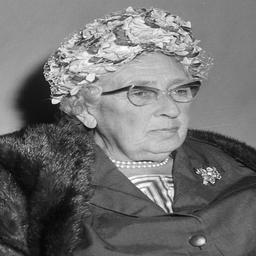

captions:  Christie at Schiphol Airport, 17 September 1964
wrong captions: Gump with United States President John F. Kennedy. A variety of visual effects were used to incorporate Tom Hanks into archive footage with various historical figures and events.
descriptions:  Black-and-white portrait photograph of Christie in later life
wrong descriptions: Louis Pasteur in 1857


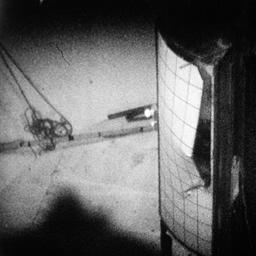

captions:  Panel similar to the SM Sector4 cover being ejected during a test performed as part of the investigation
wrong captions: McDivitt, Scott, and Schweickart train for the AS-205/208 mission in the first Block II spacecraft and space suits, which still had most of the fire hazards the Apollo1 spacecraft had.
descriptions:  Panel in the process of being blown out
wrong descriptions: Large conical structure on a pulley with a man on top and two near the base.


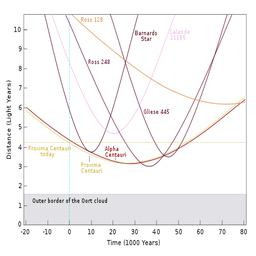

captions:  Distances of the nearest stars from 20,000 years ago until 80,000 years in the future
wrong captions: Closest stars to the Sun
descriptions:  Line graph with x-axis in thousands of years and y-axis in light years, the lines on the graph being labelled with the names of stars
wrong descriptions: A graph with seven columns labeled 0 to 6. The 0 column is "exclusively heterosexual" and is shown completely white. A gradient line showing the varying degrees of bisexual responses starts at the beginning of column 1 and rises to the end of column 5. Column 6 is "exclusively homosexual" and is shown filled with the color blue.


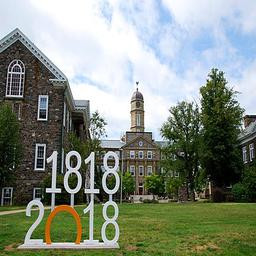

captions:  Henry Hicks Academic Administration Building is located at Dalhousie's Studley Campus, and houses many of Dalhousie's administrative offices.
wrong captions: The Republican Vilnius Psychiatric Hospital in Naujoji Vilnia (Parko g. 15), is one of the largest health facilities in Lithuania; built in 1902, it officially opened on 21 May 1903.
descriptions:  Henry Hicks Academic Administration Building at Dalhousie University
wrong descriptions: Vilnius Psychiatric Hospital 1 The Republican Vilnius Psychiatric Hospital in Naujoji Vilnia (Parko g. 15), is one of the largest health facilities in Lithuania; built in 1902, official opening on 21 May 1903


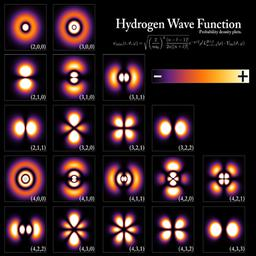

captions:  Probability densities for the first few hydrogen atom orbitals, seen in cross-section. The energy level of a bound electron determines the orbital it occupies, and the color reflects the probability of finding the electron at a given position.
wrong captions: In quantum mechanics, the behavior of an electron in an atom is described by an orbital, which is a probability distribution rather than an orbit. In the figure, the shading indicates the relative probability to "find" the electron, having the energy corresponding to the given quantum numbers, at that point.
descriptions:  A table of five rows and five columns, with each cell portraying a color-coded probability density
wrong descriptions: A table with four rows and four columns, with each cell containing a particle identifier


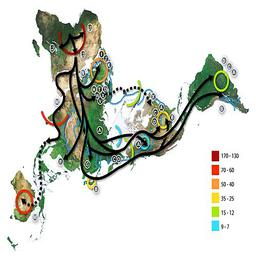

captions:  A global mapping model of human migration, based from divergence of the mitochondrial DNA (which indicates the matrilineage). Timescale (ka) indicated by colours.
wrong captions: Tantalum producers in 2015 with Rwanda being the main producer
descriptions:  Map with arrows emanating from Africa, across Eurasia, to Australia and the Americas.
wrong descriptions: One set of arrows point from Taiwan to Melanesia to Fiji/Samoa and then to the Marquesas Islands. The population then spread, some going south to New Zealand and others going north to Hawai'i. A second set start in southern Asia and end in Melanesia.


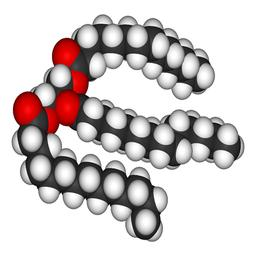

captions:  Idealized representation of a molecule of a typical triglyceride, the main type of fat. Note the three fatty acid chains attached to the central glycerol portion of the molecule.
wrong captions: One of the alchemical symbols for antimony
descriptions:  A space-filling model of an unsaturated triglyceride.
wrong descriptions: A sphere with a minus sign at lower left symbolizes the electron, while pairs of spheres with plus and minus signs show the virtual particles


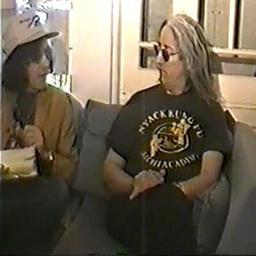

captions:  Isaac Bonewits (right) at Camp Ramblewood.
wrong captions: Navajo code talkers, Saipan, June 1944
descriptions:  Isaac Bonewits
wrong descriptions: An unshaded circle surmounted by a cross.


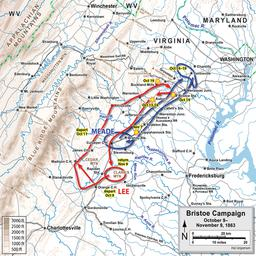

captions:  Bristoe Campaign
wrong captions: Battle of Brandy Station, June 9, 1863
descriptions:  A map of the Bristoe Campaign
wrong descriptions: A map showing Union actions and Stuart's responses at the Battle of Brandy Station


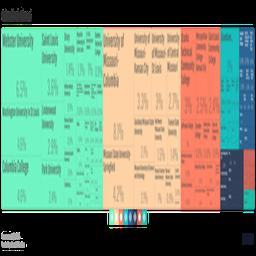

captions:   A tree map depicting Missouri schools sized by total awarded degrees relative to the total degrees awarded in Missouri. Data sourced from the 2014 NCES IPEDS report authored by the US Dept. of Education.
wrong captions: Results of the 1970 gubernatorial election in Georgia, with blue counties supporting Carter and red ones voting for Hal Suit: the relative darkness of the shade shows greater support for a candidate.
descriptions:  A tree map depicting Missouri schools
wrong descriptions: Map showing major dams and reservoirs in the Missouri River basin


In [19]:
# Inspect some results
for inc_idx in common_incorrect_idxs[:10]:
    img=images[inc_idx]
    display(img)
    cap_cor=cap_incorrect_idxs.index(inc_idx)
    desc_cor=desc_incorrect_idxs.index(inc_idx)
    print("captions: ", captions[inc_idx])
    print("wrong captions:", captions[cap_incorrect[cap_cor][0]])
    print("descriptions: ", descs[inc_idx])
    print("wrong descriptions:", descs[desc_incorrect[desc_cor][0]])
    

(15, tensor(17.0406, device='cuda:0')) (928, tensor(0.0040, device='cuda:0'))
[(15, tensor(17.0406, device='cuda:0')), (211, tensor(16.5613, device='cuda:0')), (205, tensor(15.1130, device='cuda:0')), (770, tensor(14.2849, device='cuda:0')), (879, tensor(13.2438, device='cuda:0')), (301, tensor(13.0695, device='cuda:0')), (892, tensor(12.5231, device='cuda:0')), (767, tensor(11.9491, device='cuda:0')), (768, tensor(11.9422, device='cuda:0')), (699, tensor(11.7474, device='cuda:0'))]


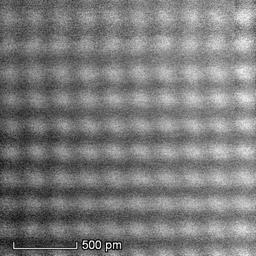

caption: High-resolution STEM-HAADF micrograph of Al atoms viewed along the  zone axis.
description: M. Tunes & S. Pogatscher, Montanuniversitt Leoben 2019 No copyrights =)


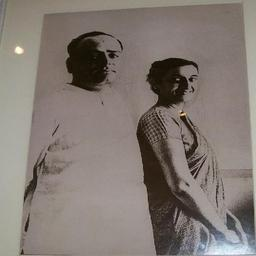

caption: Portrait of Feroze and Indira Gandhi
description: Personal Life


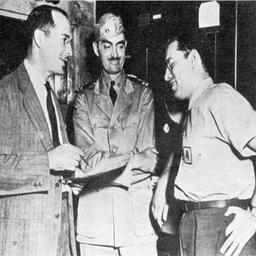

caption: Robert A. Heinlein and L. Sprague de Camp with Asimov (right), Philadelphia Navy Yard, 1944
description: Photo


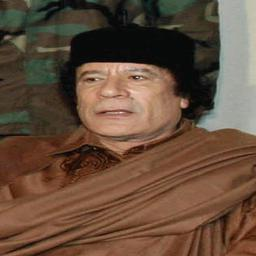

caption: Muammar Gaddafi
description: photograph


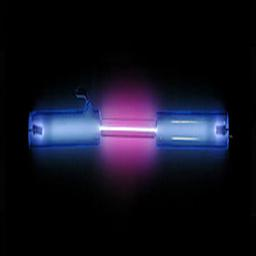

caption: Hydrogen in an electrical discharge tube
description: Greyish lustrous block with uneven cleaved surface.


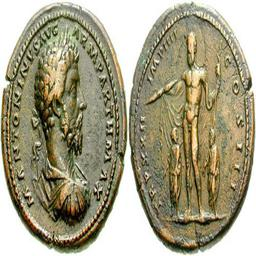

caption: Bronze medallion of Marcus Aurelius (AD 168). The reverse depicts Jupiter, flanked by Marcus and Lucius Verus. Inscription: M. ANTONINVS AVG. ARM. PARTH. MAX. / TR. P. XXII, IMP. IIII, COS III.
description: Bust of Marcus Aurelius.


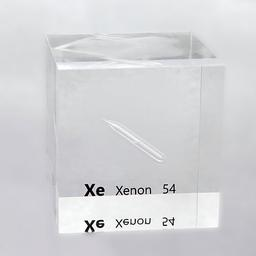

caption: Pressurized xenon gas encapsulated in an acrylic cube
description: Greyish lustrous block with uneven cleaved surface.


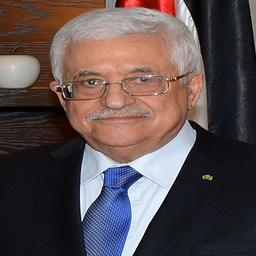

caption: Mahmoud Abbas, President of the Palestinian Authority, in 2014
description: photograph


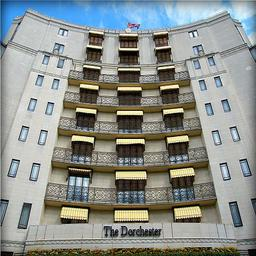

caption: Shlomo Argov was shot in the head as he left the Dorchester Hotel, Park Lane, London.
description: photograph


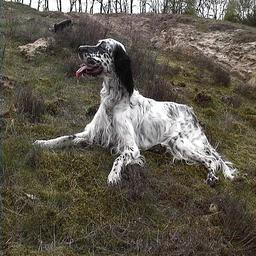

caption: An English Setter resting.
description: at rest


In [20]:
print(max(dif_score,key=lambda x:x[1]),min(dif_score,key=lambda x:x[1]))
score_highest_dif=sorted(dif_score,key=lambda x:x[1], reverse=True)

highest=score_highest_dif[:10]
print(highest)
for i in range(10):
    idx,_=highest[i]
    display(images[idx])
    print("caption:",captions[idx])
    print("description:",descs[idx])

## Part 2: Rational Speech Acts (RSA)

Now we will implement RSA on top of our simple image retrieval system. Recall that the idea of RSA is to model how likely an utterance is _in context_. Even if a caption scores the highest for a given image based on raw similarity score, it may no longer be the best text in the context of other, alternative captions for the image. We will implement this idea and investigate how it changes retrieval performance.

We'll work with the examples from Part 1 where the true image is not in the top 10 retrieval results for a given caption. You should double-check your retrieval performance matches the expected numbers before you proceed; otherwise, you'll be working with different examples here. 

In [21]:
incorrect = [b[:10] for i, b in enumerate(batch_outputs_cap) if i not in b[:10]]
incorrect_idxs = [i for i, b in enumerate(batch_outputs_cap) if i not in b[:10]]
assert len(incorrect) == 92, "Your retrieval system results do not match ours."

In [22]:
print(len(incorrect),incorrect_idxs)

92 [6, 9, 27, 35, 37, 61, 64, 74, 80, 91, 93, 131, 141, 149, 150, 154, 157, 160, 161, 178, 203, 208, 224, 229, 231, 249, 251, 267, 268, 271, 289, 329, 338, 360, 362, 376, 377, 394, 405, 409, 413, 439, 460, 469, 494, 520, 523, 530, 560, 563, 571, 580, 608, 609, 629, 643, 644, 645, 659, 661, 669, 670, 671, 672, 703, 711, 721, 735, 750, 756, 777, 789, 805, 806, 812, 833, 834, 853, 890, 908, 914, 919, 925, 930, 931, 938, 942, 945, 951, 955, 962, 969]


For each of the captions with an incorrect retrieval result, we'll get the top 10 retrieved images and the true captions for each of those 10 images. The alternative captions will form the context for RSA.

Let's implement the RSA functions that we'll run on these contexts.

First, implement a **literal listener** which retrieves the top images for a given caption without modeling how likely a speaker is to generate those captions.
    
This should look similar to your rank_images retrieval function from Part 1, except the function should now return softmax-normalized probabilities (which will then be used by the pragmatic speaker).

In [23]:
def literal_listener(captions, images):
    """
    Args:
        captions: list of N captions
        images: list of N images
    Returns:
        a NxN array of normalized conditional probabilities,
        where A[i][j] = p(image j | caption i)
    """
    # YOUR CODE HERE
    ###
#     print(captions,images)
    inputs= processor(text=captions, images=images,return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        outputs=model(**inputs)
        scores = outputs.logits_per_text
        listener_probs=scores.softmax(dim=1).cpu()
    assert np.allclose(listener_probs.sum(1), 1)
    return listener_probs

Now, we'll implement a **pragmatic speaker**. For a given image, the pragmatic speaker is more likely to select utterances that elicit the right inference in the listener (i.e. the more likely the listener is to choose the right image based on the caption, the more likely the speaker is to use that caption).

The pragmatic speaker should call the literal_listener within the function. Normalize your speaker probabilities by dividing by the sum (rather than using softmax), matching the implementation in lecture.

In [24]:
def pragmatic_speaker(captions, images):
    """
    Args:
        captions: list of N captions
        images: list of N images
    Returns:
        a NxN array of normalized conditional probabilities,
        where A[i][j] = p(caption i | image j)
    """
    # YOUR CODE HERE
    ###
#     print(captions,images)
    listener_probs = literal_listener(captions, images)
    speaker_probs = listener_probs / listener_probs.sum(axis=0, keepdims=True)
#     print(listener_probs.size())
    assert np.allclose(speaker_probs.sum(0), 1)
    return speaker_probs

Finally, implement a **pragmatic listener**, which models how a pragmatic speaker would select utterances. Similarly, you should call pragmatic_speaker within the function and use sum-normalization instead of softmax.

In [25]:
def pragmatic_listener(captions, images):
    """
    Args:
        captions: list of N captions
        images: list of N images
    Returns:
        a NxN array of normalized conditional probabilities,
        where A[i][j] = p(image j | caption i)
    """
    # YOUR CODE HERE
    ###
    speaker_probs=pragmatic_speaker(captions, images)
    listener_probs=speaker_probs/ speaker_probs.sum(axis=1, keepdims=True)
    assert np.allclose(listener_probs.sum(1), 1)
    return listener_probs

Now let's evaluate the pragmatic listener on each context. You should get >20 examples (out of 92) where pragmatics fixes the error.

In [26]:
improved = 0
predictions = []
corrected_idx=[]

for true_idx, topk_idxs in zip(incorrect_idxs, incorrect):
    img_context = [images[idx] for idx in [true_idx] + topk_idxs]
    caption_context = [captions[idx] for idx in [true_idx] + topk_idxs]
    # Call your pragmatic listener and increment `improved` if the top image candidate is now correct
    # YOUR CODE HERE
    ###
    
    pragmatic_probs=pragmatic_listener(caption_context,img_context)
    true_prob=pragmatic_probs[0][0]
    if true_prob>max(pragmatic_probs[0][1:]):
        improved+=1
        corrected_idx.append(true_idx)
    # Save prediction outputs
    predictions.append(np.array(pragmatic_probs))
        
print(f"# examples where pragmatics fixes the error: {improved} / {len(incorrect)}")
np.save("pragmatic_preds.npy", np.array(predictions))

# examples where pragmatics fixes the error: 26 / 92


In [28]:
test_p=np.load('pragmatic_preds.npy')
type(test),type(test[0])

(numpy.ndarray, numpy.ndarray)

## Qualitative Analysis Part 2: RSA

In your report:
* Report the # of examples that were previously incorrect that are now correct (the correct image is now the top candidate).
* Investigate some qualitative examples to get an intuition of why RSA fixes these issues and discuss one of these examples (e.g. compare the literal listener probabilities to the pragmatic listener probabilities and think about why they changed). 

In [29]:
# YOUR CODE HERE
###
print(corrected_idx)
corrected5=corrected_idx[:5]
# predictions就是pragmatic的分布,corrected是对每个caption来说，对上了正确的image，看每个caption的prob分布?
corrected_prag_probs=[predictions[incorrect_idxs.index(i)][0] for i in corrected5]
print(corrected_prag_probs)
corrected_lit_probs=literal_listener([captions[i] for i in corrected5],[images[i] for i in corrected5])
print(corrected_lit_probs)


[6, 9, 27, 91, 131, 149, 161, 208, 267, 268, 377, 394, 460, 469, 629, 671, 721, 735, 756, 805, 833, 834, 853, 942, 945, 951]
[array([0.39939505, 0.16904284, 0.12369081, 0.14210194, 0.0264569 ,
       0.02519011, 0.01758784, 0.0108163 , 0.01204345, 0.00473025,
       0.06894453], dtype=float32), array([0.49738052, 0.17297801, 0.13866025, 0.06418903, 0.03713131,
       0.03156635, 0.01316799, 0.0129473 , 0.01136933, 0.01077368,
       0.00983614], dtype=float32), array([0.45334852, 0.08487279, 0.08156343, 0.08954936, 0.05820125,
       0.05425228, 0.0484156 , 0.03625271, 0.03806879, 0.03311624,
       0.02235907], dtype=float32), array([0.4398139 , 0.30800635, 0.08322202, 0.04051106, 0.02084174,
       0.02507137, 0.02398085, 0.01858329, 0.01707919, 0.01238113,
       0.01050905], dtype=float32), array([0.47017092, 0.16958791, 0.09408756, 0.0431391 , 0.06923378,
       0.03924959, 0.09638536, 0.00910052, 0.00420695, 0.00237251,
       0.00246585], dtype=float32)]
tensor([[9.8780e-01, 5.8

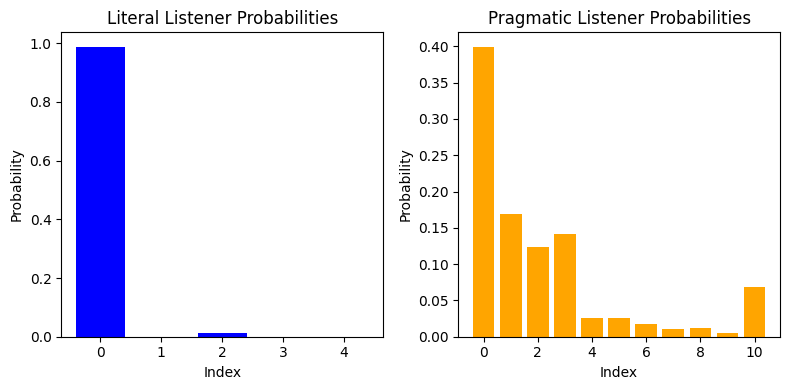

In [30]:
import matplotlib.pyplot as plt

literal_listener_probs=corrected_lit_probs[0]
pragmatic_listener_probs=corrected_prag_probs[0]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(literal_listener_probs)), literal_listener_probs, color='blue')
plt.title('Literal Listener Probabilities')
plt.xlabel('Index')
plt.ylabel('Probability')


plt.subplot(1, 2, 2)
plt.bar(np.arange(len(pragmatic_listener_probs)), pragmatic_listener_probs, color='orange')
plt.title('Pragmatic Listener Probabilities')
plt.xlabel('Index')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

## Part 3: Image Captioning

Finally, we'll explore caption generation using a pretrained model, and how RSA can help us generate more discriminative captions.

In [31]:
from transformers import BlipProcessor, BlipForConditionalGeneration

cap_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
cap_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

In [33]:
# Generate image captions for a subset of data
people = [d for d in val if " man " in d["description"]["raw"] or " woman " in d["description"]["raw"]]
people = people[:100]
people_images = [Image.open(f"/kaggle/working/resized/{ex['filename']}") for ex in people]

We'll compare the image retrieval performance for a literal captioner to that of a pragmatic captioner.

First, implement a literal captioner by just decoding the greedy output from the base captioning model.

In [34]:
def literal_captioner(image):
    # YOUR CODE HERE
    ###
    
    inputs = cap_processor(image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        output = cap_model.generate(**inputs)
        caption = cap_processor.decode(output[0], skip_special_tokens=True)
       
    return caption

Now, implement a pragmatic captioner by sampling candidate captions from a base captioning model, and then using the `pragmatic_speaker` function you implemented earlier to re-rank captions using the other images in the subset of 100 images of people to normalize your speaker probabilities. Use temperature 0.6 and top_p 0.95 for sampling.

In [35]:
def generate_candidate_captions(image, k=10):
    """Generate k candidate captions for an image."""
    # YOUR CODE HERE
    ###
    inputs=cap_processor(image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = cap_model.generate(
        **inputs,
        num_return_sequences=k,  
        temperature=0.6,  
        top_p=0.95,  
        do_sample=True)
        candidates = [cap_processor.decode(output, skip_special_tokens=True) for output in outputs]
        
    assert isinstance(candidates, list) and len(candidates) == k and isinstance(candidates[0], str)
    return candidates
    
def pragmatic_captioner(image, context_images):
    """Generate a caption for the image using a set of context images."""
    # Generate candidate captions
    # YOUR CODE HERE
    candidate_captions=generate_candidate_captions(image)

    # Rank captions with the pragmatic_speaker and return the best one
#     the first is the real image
    context_images=[image]+context_images
    pragmatic_captions = pragmatic_speaker(candidate_captions,context_images) # YOUR CODE HERE
#     print(len(pragmatic_captions),len(pragmatic_captions[0]))
    best_idx=np.argmax([pragmatic_captions[i][0] for i in range(len(pragmatic_captions))])
    pragmatic_caption=candidate_captions[best_idx]
    return pragmatic_caption

In [36]:
results = []
n_people = len(people_images)
for i in range(len(people_images)):
    image=people_images[i]
    literal_caption = literal_captioner(people_images[i])
    # Call the pragmatic captioner and return the caption after RSA and the candidate captions
    # Be careful when constructing the context images, which should not include the true image.
#     context_images = [img for idx, img in enumerate(people_images) if idx != i]
    context_images=[]
    if i<=5:
        context_images=people_images[:i]+people_images[i+1:10]
    elif i>=(len(people_images)-5):
        context_images=people_images[n_people-10:i]+people_images[i+1:n_people]
    else:
        context_images=people_images[i-4:i]+people_images[i+1:i+5]

    pragmatic_caption = pragmatic_captioner(image, context_images) # YOUR CODE HERE
    results.append((literal_caption, pragmatic_caption))

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


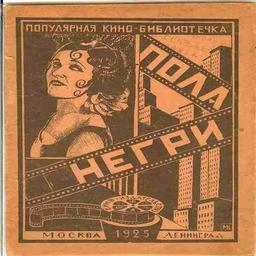

Literal caption:  a book with a woman in the middle and a movie strip
Pragmatic caption:  the cover of a book with an image of a woman with a camera and film strip


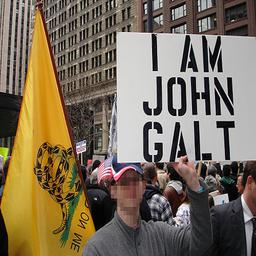

Literal caption:  a group of people holding signs in the street
Pragmatic caption:  a man holding a sign


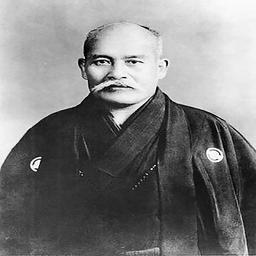

Literal caption:  a man in a kimono robe and a hat
Pragmatic caption:  portrait of a man in kimonog, c 1880


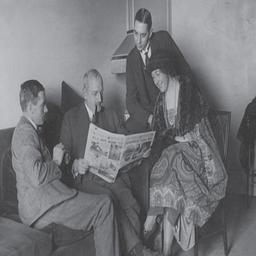

Literal caption:  a group of people sitting in a room
Pragmatic caption:  a group of men sitting around a table reading newspapers


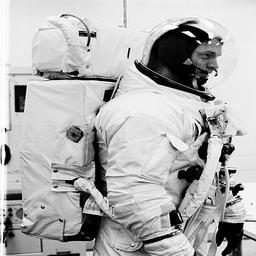

Literal caption:  two men in spacesuits in a room
Pragmatic caption:  a black and white photo of two astronauts


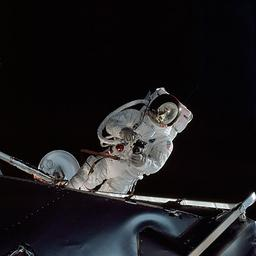

Literal caption:  astronaut in space station
Pragmatic caption:  astronaut sitting on the bottom of the space station


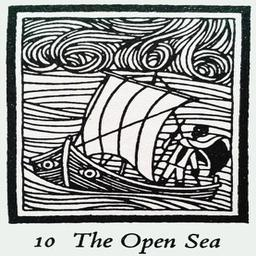

Literal caption:  the cover of the book, the opp sea
Pragmatic caption:  an image of a boat in a sea with the words the op sea


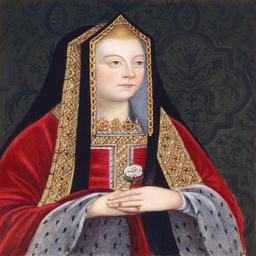

Literal caption:  a painting of a woman in a red dress
Pragmatic caption:  a painting of a woman wearing a red robe, a white robe and a gold crown


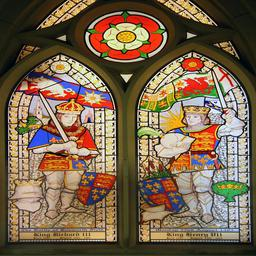

Literal caption:  a stained glass window
Pragmatic caption:  a stained window in a stone building with a couple on horseback


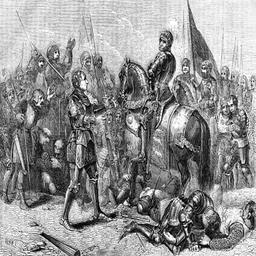

Literal caption:  the battle of the nations
Pragmatic caption:  an engraving depicting the battle between the armies of the english and french wars


In [37]:
# Inspect some results
for img, r in zip(people_images[:10], results[:10]):
    display(img)
    print("Literal caption: ", r[0])
    print("Pragmatic caption: ", r[1])

Now, if we were to do image retrieval with our generated captions, let's take a look at how retrieval performance changes if we retrieve based on the greedy output from the captioner vs. the more discriminative captions selected by RSA.

Your top-1 retrieval accuracy with pragmatic captions should be >70%.

In [38]:
literal_retrieval_outputs = rank_images([r[0] for r in results], people_images)
print("Top-1 accuracy (literal):", top1_accuracy(literal_retrieval_outputs))
pragmatic_retrieval_outputs = rank_images([r[1] for r in results], people_images)
print("Top-1 accuracy (pragmatic):", top1_accuracy(pragmatic_retrieval_outputs))

np.save("image_retrieval_pragmatic.npy", pragmatic_retrieval_outputs)

Top-1 accuracy (literal): 0.55
Top-1 accuracy (pragmatic): 0.8


## Qualitative Analysis Part 3: Captioning

In your report:
* Look at a few examples of captions generated by the literal and the pragmatic captioner. What are some qualitative trends and why would they come out of RSA inference?

# Submission

Your final submission should include the following files:

* hw5.ipynb (this file; please rename to match)
* image_retrieval_caption.npy
* image_retrieval_desc.npy
* pragmatic_preds.npy
* image_retrieval_pragmatic.npy
* report.pdf (containing qualitative analysis for Parts 1-3)